In [3]:
from omegaconf import OmegaConf as om
from mosaicfm.model import ComposerSCGPTModel
from mosaicfm.tasks import get_batch_embeddings
from mosaicfm.tokenizer import GeneVocab
import torch
import scanpy as sc
import numpy as np
import pandas as pd
from sklearn.neighbors import kneighbors_graph
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
def compute_lisi_scores(emb, labels, k):
    nng = kneighbors_graph(emb, n_neighbors=k).tocoo()
    labels = pd.Categorical(labels).codes
    self_id = labels[nng.row]
    ne_id = labels[nng.col]

    _, c = np.unique(labels, return_counts=True)
    theoretic_score = ((c / c.sum()) ** 2).sum()
    return (self_id == ne_id).mean() / theoretic_score

In [13]:
model_paths = {
    "5ep": "/vevo/umair/data/scgpt-models/mosaicfm-adapt-rif-constant-lr/ep5-ba35420-rank0.pt",
    "10ep": "/vevo/umair/data/scgpt-models/mosaicfm-adapt-rif-constant-lr/ep10-ba70840-rank0.pt",
    "15ep": "/vevo/umair/data/scgpt-models/mosaicfm-adapt-rif-constant-lr/ep15-ba106260-rank0.pt"
}

model_name = "15ep"

In [14]:
sample_data_path = "/vevo/umair/data/Kim2020_Lung.h5ad"
# Download from https://drive.usercontent.google.com/download?id=1z_0vWYMhRuRiD1EyhuFtY9ReIR0msWaL&authuser=0
vocab_path = "/vevo/umair/data/scgpt-models/scgpt-70m-1024-fix-norm-apr24-data/vocab.json"
vocab = GeneVocab.from_file(vocab_path)
adata = sc.read_h5ad(sample_data_path)

# gene_col = "feature_name"
gene_col = "gene_name"
# cell_type_key = "cell_line_orig"
cell_type_key = "cell_type"
# batch_key = "dataset_id"
batch_key = "sample"

adata.var["id_in_vocab"] = [
    vocab[gene] if gene in vocab else -1 for gene in adata.var[gene_col]
]
gene_ids_in_vocab = np.array(adata.var["id_in_vocab"])
print(
    f"match {np.sum(gene_ids_in_vocab >= 0)}/{len(gene_ids_in_vocab)} genes "
    f"in vocabulary of size {len(vocab)}."
)
adata = adata[:, adata.var["id_in_vocab"] >= 0]

vocab.set_default_index(vocab["<pad>"])
genes = adata.var[gene_col].tolist()
gene_ids = np.array(vocab(genes), dtype=int)

match 20563/20793 genes in vocabulary of size 60736.


In [15]:
model_config_path = "/vevo/umair/data/scgpt-models/scgpt-70m-1024-fix-norm-apr24-data/model_config.yml"
collator_config_path = "/vevo/umair/data/scgpt-models/scgpt-70m-1024-fix-norm-apr24-data/collator_config.yml"
model_file = model_paths[model_name]
model_config = om.load(model_config_path)
collator_config = om.load(collator_config_path)

model = ComposerSCGPTModel(model_config = model_config,
                          collator_config = collator_config)

model.load_state_dict(torch.load(model_file)["state"]["model"],
                     strict=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# get cell embeddings
cell_embeddings = get_batch_embeddings(
    adata=adata,
    model=model.model,
    vocab=vocab,
    gene_ids=gene_ids,
    model_cfg=model_config,
    collator_cfg=collator_config,
    batch_size=512,
    max_length=1200,
    return_gene_embeddings=False
)

Embedding cells: 100%|██████████| 32493/32493 [00:53<00:00, 602.55it/s]


/tmp/ipykernel_19211/3444567446.py:2: ImplicitModificationWarning: Setting element `.obsm['15ep']` of view, initializing view as actual.
  adata.obsm[model_name] = cell_embeddings


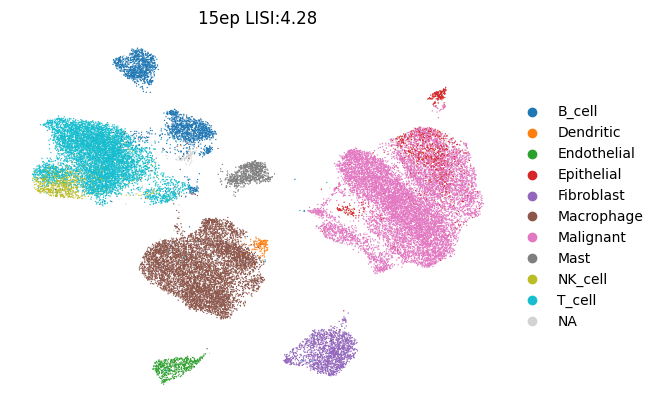

In [16]:
lisi_score = compute_lisi_scores(cell_embeddings, adata.obs[cell_type_key].values, 20) 
adata.obsm[model_name] = cell_embeddings
sc.pp.neighbors(adata, use_rep=model_name)
sc.tl.umap(adata)
fig = sc.pl.umap(adata, 
           color=[cell_type_key], 
           frameon=False, 
           wspace=0.4, 
           title=[f"{model_name} LISI:{lisi_score:.2f}"],
            return_fig=True)

plt.show()